In [1]:
import pandas as pd
import os
import numpy as np

In [ ]:
os.environ["OPENAI_API_KEY"] = ""     #add your OpenAI API key

In [3]:
# read data

data = pd.read_csv("data.csv", usecols=['message_clean'])
data.head()

,message_clean
0,aethero support trouble find clear documentati...
1,experience critical issue user permission prod...
2,aethero support experience urgent issue deploy...
3,aethero support team write improvement api dev...
4,aethero support quick question api monitor das...


In [4]:
# tokenize data

docs = data["message_clean"].tolist()

In [5]:
# create bigram tokenizer
from sklearn.feature_extraction.text import CountVectorizer

bigram_vectorizer = CountVectorizer(
    ngram_range=(2, 2),    # Only bigrams
    max_features=1000      # Top 1000 bigrams by frequency
)

In [6]:
# set model to train on tokenized data for bigrams in random state
from turftopic import FASTopic

topic_size  = 10
model = FASTopic(n_components = topic_size, 
                 vectorizer = bigram_vectorizer,
                 random_state = 32).fit(docs)

Output()

[14:52:12] Documents encoded.                                                                       ]8;id=876033;file://c:\Users\xpetr\.conda\envs\Turftopic\Lib\site-packages\turftopic\models\fastopic.py\fastopic.py]8;;\:]8;id=105607;file://c:\Users\xpetr\.conda\envs\Turftopic\Lib\site-packages\turftopic\models\fastopic.py#157\157]8;;\

           Term extraction done.                                                                    ]8;id=50985;file://c:\Users\xpetr\.conda\envs\Turftopic\Lib\site-packages\turftopic\models\fastopic.py\fastopic.py]8;;\:]8;id=95763;file://c:\Users\xpetr\.conda\envs\Turftopic\Lib\site-packages\turftopic\models\fastopic.py#161\161]8;;\

[14:52:18] Model fitting done.                                                                      ]8;id=666466;file://c:\Users\xpetr\.conda\envs\Turftopic\Lib\site-packages\turftopic\models\fastopic.py\fastopic.py]8;;\:]8;id=503846;file://c:\Users\xpetr\.conda\envs\Turftopic\Lib\site-packages\turftopic\models\fastopic.py#164\164]8;;\

In [7]:
# fit model to data
topic_data = model.prepare_topic_data(docs)

# create document-term matrix
dtm = topic_data.document_topic_matrix

# assign topics to each document
topic_assignments = np.argmax(dtm, axis=1)
topics = topic_assignments.tolist()

# Merge topic assignments with data on index
data_with_topics = data.copy()
data_with_topics['topic_assignment'] = topic_assignments

In [8]:
# use the Namer to label topics
from turftopic.namers import OpenAITopicNamer

namer = OpenAITopicNamer("gpt-4o-mini")
model.rename_topics(namer)

Output()

In [9]:
# create a dataframe with labelled topics
topics_df = model.topics_df()
topics_df.columns = ['topic_id', 'topic_name', 'topic_words']
topics_df

,topic_id,topic_name,topic_words
0,0,IAM Role Access Issues,"access resource, aetheros iam, issue iam, iam ..."
1,1,Collaborative API Development Enhancement,"dear aethero, incredibly beneficial, api devel..."
2,2,API Access Management,"rate limit, access api, access specific, speci..."
3,3,Service Disruption Management,"issue api, disruption service, impact live, da..."
4,4,Mercury Compiler Error Troubleshooting,"issue mercury, error mercury, compiler error, ..."
5,5,Business Impact and Recovery Strategies,"business operation, time resolution, estimate ..."
6,6,Project Mercury Guidance Support,"support work, trouble understand, provide guid..."
7,7,Performance Optimization Dashboard,"average response, improvement cloud, resource ..."
8,8,Managing API Latency Challenges,"latency spike, experience intermittent, peak h..."
9,9,Cloud Deployment Errors,"deploy mercury, deployment process, aethero cl..."


In [10]:
# Wide format with topic_id as columns and topic_words as values
wide_topics = topics_df.pivot_table(
    index=None, 
    columns='topic_id', 
    values='topic_words', 
    aggfunc='first'
)

# Add topic names as a second row
wide_topics.columns = [f"{col}: {topics_df.loc[topics_df['topic_id']==col, 'topic_name'].values[0]}" for col in wide_topics.columns]

In [11]:
# Reshape to wide format: each topic_id/topic_name is a column, each row is a topic_word rank

# First, split and explode
topics_long = topics_df.copy()
topics_long['topic_word'] = topics_long['topic_words'].str.split(',')
topics_long = topics_long.explode('topic_word')
topics_long['topic_word'] = topics_long['topic_word'].str.strip()

# Add a rank for each word within a topic (optional, for row order)
topics_long['word_rank'] = topics_long.groupby('topic_id').cumcount() + 1

# Pivot to wide format: columns are (topic_id, topic_name), rows are word_rank, values are topic_word
wide = topics_long.pivot(index='word_rank', columns=['topic_id', 'topic_name'], values='topic_word')

# For MultiIndex columns: keep columns where the first level is numeric
wide_numeric = wide[[col for col in wide.columns if str(col[0]).isdigit()]]

In [12]:
wide

topic_id,0,1,2,3,4,5,6,7,8,9
topic_name,IAM Role Access Issues,Collaborative API Development Enhancement,API Access Management,Service Disruption Management,Mercury Compiler Error Troubleshooting,Business Impact and Recovery Strategies,Project Mercury Guidance Support,Performance Optimization Dashboard,Managing API Latency Challenges,Cloud Deployment Errors
word_rank,,,,,,,,,,
1,access resource,dear aethero,rate limit,issue api,issue mercury,business operation,support work,average response,latency spike,deploy mercury
2,aetheros iam,incredibly beneficial,access api,disruption service,error mercury,time resolution,trouble understand,improvement cloud,experience intermittent,deployment process
3,issue iam,api development,access specific,impact live,compiler error,estimate time,provide guidance,resource usage,peak hour,aethero cloud
4,iam role,team write,specific api,dashboard show,unexpected token,production api,role iam,however suggestion,response times,mercury application
5,assign role,sincerely isabella,specific cloud,monitor dashboard,late version,impact business,role inheritance,real time,support experience,issue deploy
6,specific role,async await,role access,resolve urgently,face critical,major outage,support trouble,improvement api,spike api,aetheros cloud
7,unable access,support write,user authentication,major disruption,language compiler,impacting business,project mercury,service month,intermittent latency,cloud environment
8,role user,write improvement,service cloud,provide update,check code,complete outage,work project,management dashboard,times api,deployment pipeline


In [13]:
# Remove MultiIndex: flatten columns to single level by joining with underscore
wide_flat = wide.copy()
if isinstance(wide_flat.columns, pd.MultiIndex):
    wide_flat.columns = [': '.join([str(i) for i in col if i != '']) for col in wide_flat.columns]

In [14]:
cleaned_column_list = []

for col in wide_flat.columns.tolist():
    # Remove numbers and colons from each column name
    cleaned_col = ''.join(char for char in str(col) if not char.isdigit() and char != ':')
    cleaned_col = cleaned_col.strip()  # Remove extra whitespace
    if cleaned_col:  # Only add non-empty strings
        cleaned_column_list.append(cleaned_col)

In [15]:
# Remove MultiIndex: flatten columns to single level by joining with underscore
wide_flat = wide.copy()
if isinstance(wide_flat.columns, pd.MultiIndex):
    wide_flat.columns = [': '.join([str(i) for i in col if i != '']) for col in wide_flat.columns]

# # Now keep only columns where the name starts with a digit
wide_numeric = wide_flat[[col for col in wide_flat.columns if str(col)[0].isdigit()]]

# Create list of tuples following the structure (topic_id, topic_name, topic_words)
topics_list = []

for column in wide_numeric.columns:
    # Extract topic_id from column name (first part before colon)
    topic_id = int(column.split(':')[0])
    
    # Extract topic_name from column name (part after colon)
    topic_name = column.split(':', 1)[1].strip()
    
    # Get all words for this topic (non-null values in this column)
    words = wide_numeric[column].dropna().tolist()
    topic_words = ', '.join(words)
    
    # Create tuple and add to list
    topics_list.append((topic_id, topic_name, topic_words))

# Sort by topic_id to ensure proper order
topics_list.sort(key=lambda x: x[0])

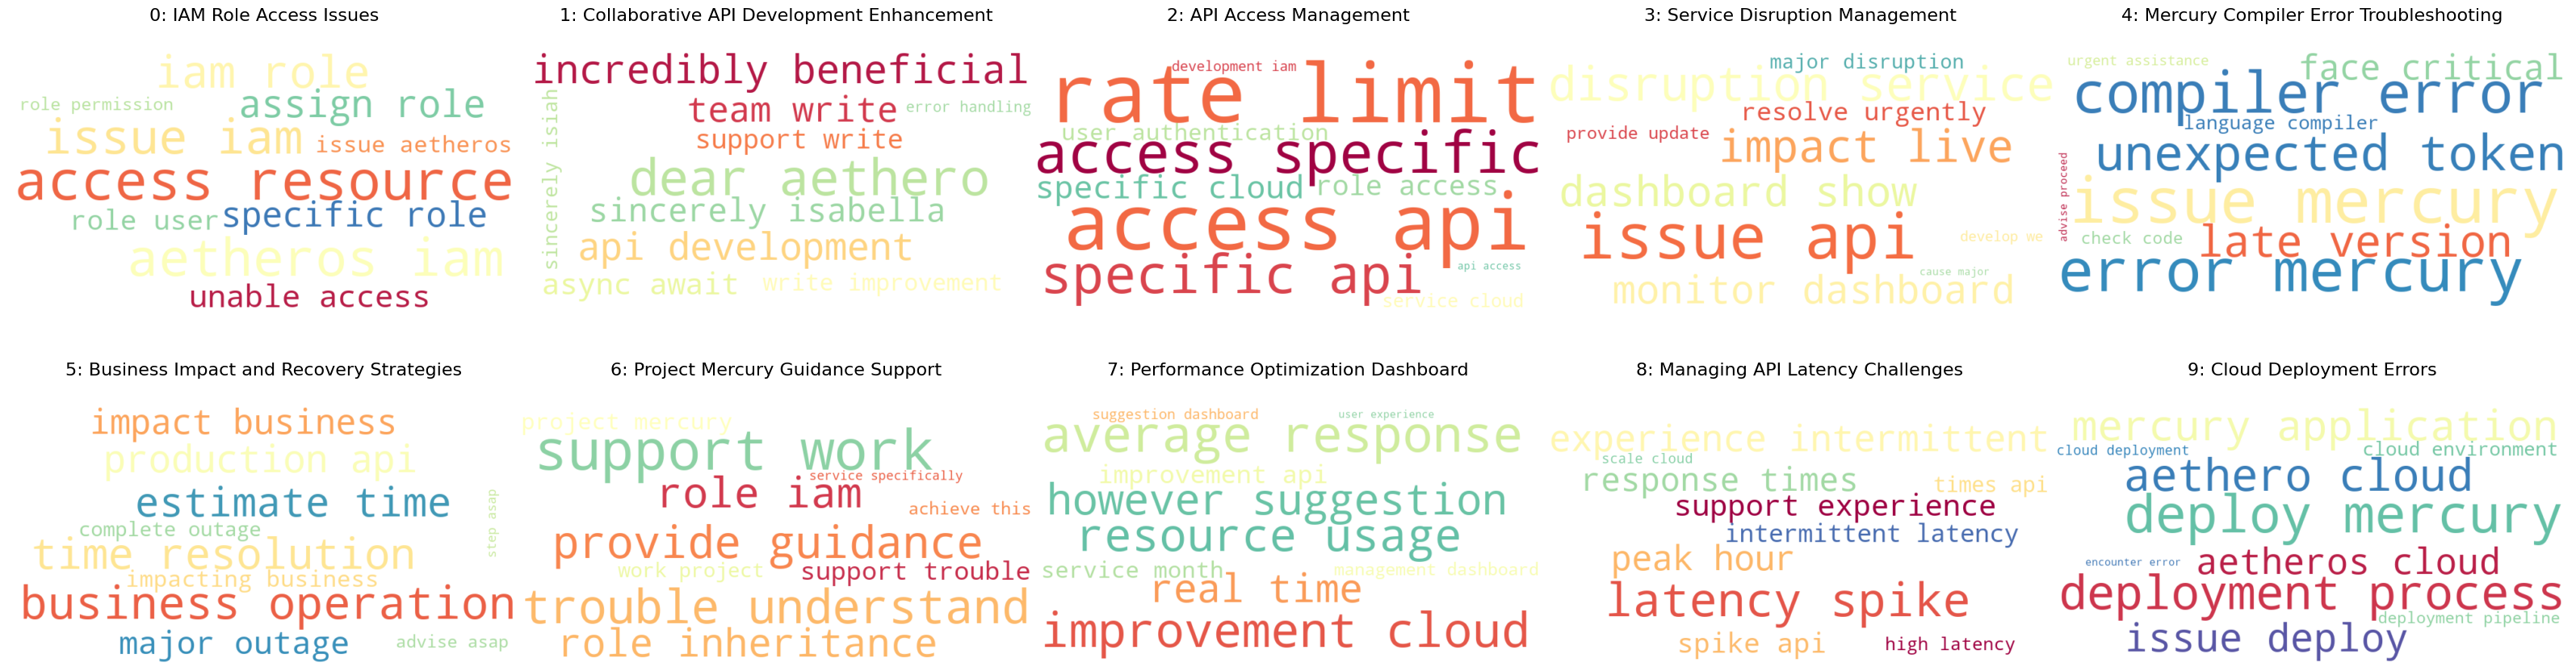

In [16]:
# visualize the topics in bigram word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(32, 12))
axes = axes.flatten()

for idx, (topic_id, topic_name, keywords) in enumerate(topics_list):
    raw_tokens = keywords.split(", ")
    tokens = [token.strip().replace("ˍ", " ") for token in raw_tokens]
    freqs = {token: len(tokens) - i for i, token in enumerate(tokens)}

    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          colormap='Spectral', collocations=False).generate_from_frequencies(freqs)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    # Shift title above the axes, normal weight
    axes[idx].set_title(f"{topic_id}: {topic_name}", fontsize=16, weight='normal', y=1.1)
    axes[idx].axis("off")

# Remove extra subplot axes (if any)
for j in range(len(topics_list), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=-0.4)
plt.savefig("FAST_10_wordcloud.png", dpi=100, bbox_inches='tight')
plt.show()